In [1]:
%matplotlib inline
from __future__ import absolute_import
from __future__ import print_function
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(1337)  # for reproducibility

from scipy.misc import imresize

In [4]:
import theano
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.utils import np_utils
from keras.utils import np_utils, generic_utils
from keras.optimizers import Adam, SGD


In [5]:
from seya.layers.attention import SpatialTransformer

In [6]:
from keras import backend as K
K.set_image_dim_ordering("th")

In [9]:
from keras import backend 
backend.backend()

u'theano'

In [10]:
batch_size = 128
nb_classes = 10
nb_epoch = 12

DIM = 60
mnist_cluttered = "../../mnist_cluttered_60x60_6distortions.npz"

In [11]:
data = np.load(mnist_cluttered)
X_train, y_train = data['x_train'], np.argmax(data['y_train'], axis=-1)
X_valid, y_valid = data['x_valid'], np.argmax(data['y_valid'], axis=-1)
X_test, y_test = data['x_test'], np.argmax(data['y_test'], axis=-1)
# reshape for convolutions
X_train = X_train.reshape((X_train.shape[0], 1, DIM, DIM))
X_valid = X_valid.reshape((X_valid.shape[0], 1, DIM, DIM))
X_test = X_test.reshape((X_test.shape[0], 1, DIM, DIM))

y_train = np_utils.to_categorical(y_train, nb_classes)
y_valid = np_utils.to_categorical(y_valid, nb_classes)
y_test = np_utils.to_categorical(y_test, nb_classes)

print("Train samples: {}".format(X_train.shape))
print("Validation samples: {}".format(X_valid.shape))
print("Test samples: {}".format(X_test.shape))

input_shape = X_train.shape[1:]

Train samples: (50000, 1, 60, 60)
Validation samples: (10000, 1, 60, 60)
Test samples: (10000, 1, 60, 60)


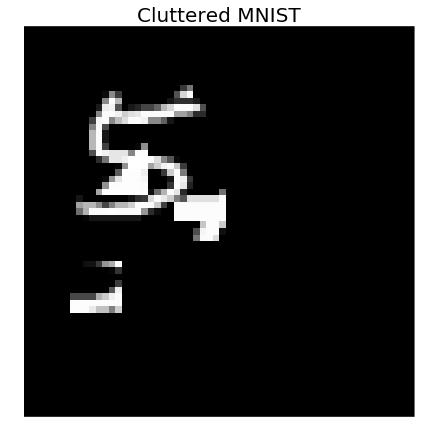

In [12]:
plt.figure(figsize=(7,7))
plt.imshow(X_train[101].reshape(DIM, DIM), cmap='gray', interpolation='none')
plt.title('Cluttered MNIST', fontsize=20)
plt.axis('off')
plt.show()

In [13]:
# initial weights
b = np.zeros((2, 3), dtype='float32')
b[0, 0] = 1
b[1, 1] = 1
W = np.zeros((50, 6), dtype='float32')
weights = [W, b.flatten()]

In [14]:
locnet = Sequential()
locnet.add(MaxPooling2D(pool_size=(2,2), input_shape=input_shape))
locnet.add(Convolution2D(20, 5, 5))
locnet.add(MaxPooling2D(pool_size=(2,2)))
locnet.add(Convolution2D(20, 5, 5))

locnet.add(Flatten())
locnet.add(Dense(50))
locnet.add(Activation('relu'))
locnet.add(Dense(6, weights=weights))
#locnet.add(Activation('sigmoid'))

In [15]:
model = Sequential()

model.add(SpatialTransformer(localization_net=locnet,
                             downsample_factor=3, input_shape=input_shape))

model.add(Convolution2D(32, 3, 3, border_mode='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Convolution2D(32, 3, 3))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(256))
model.add(Activation('relu'))

model.add(Dense(nb_classes))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam')

/home/bigdata/anaconda2/lib/python2.7/site-packages/keras/engine/topology.py:371: UserWarning: The `regularizers` property of layers/models is deprecated. Regularization losses are now managed via the `losses` layer/model property.
  warnings.warn('The `regularizers` property of '
/home/bigdata/anaconda2/lib/python2.7/site-packages/keras/engine/topology.py:379: UserWarning: The `regularizers` property of layers/models is deprecated. Regularization losses are now managed via the `losses` layer/model property.
  warnings.warn('The `regularizers` property of layers/models '


In [24]:
# Old, deprecated
"""
    # XX = model.get_input()
    # YY = model.layers[0].get_output()
    # F = theano.function([XX], YY)
    # F = theano.function([model.get_input()], model.layers[0].get_output())
    #convout1_f = theano.function([model.layers[0].input], convout1.output)
    #convout2_f = theano.function([convout2.get_input(train=False)], convout2.get_output(train=False))
"""

# XX = model.layers[0].input
# YY = model.layers[0].output
# F = theano.function([XX], YY)

XX = model.input
YY = model.layers[0].output
#F = K.function([XX], YY)
F = K.function([XX], [YY])

In [25]:
print(X_train.shape[0]/batch_size)

195


----------------------------------------
 9984/10000 [============================>.] - ETA: 0sEpoch: 0 | Valid: 0.447458524227 | Test: 0.448183641768


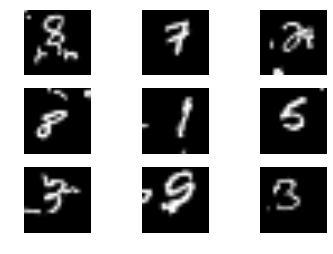

----------------------------------------
 9984/10000 [============================>.] - ETA: 0sEpoch: 1 | Valid: 0.464775819945 | Test: 0.465333017087
----------------------------------------
 9984/10000 [============================>.] - ETA: 0sEpoch: 2 | Valid: 0.373529179549 | Test: 0.376723116612
----------------------------------------
 9984/10000 [============================>.] - ETA: 0sEpoch: 3 | Valid: 0.412299827242 | Test: 0.410756937873
----------------------------------------
 9984/10000 [============================>.] - ETA: 0sEpoch: 4 | Valid: 0.275784223735 | Test: 0.283096393645
----------------------------------------
 9984/10000 [============================>.] - ETA: 0sEpoch: 5 | Valid: 0.272769605339 | Test: 0.273598556864


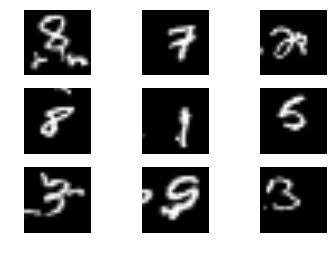

----------------------------------------
 9984/10000 [============================>.] - ETA: 0sEpoch: 6 | Valid: 0.285786412799 | Test: 0.283544698602
----------------------------------------
 9984/10000 [============================>.] - ETA: 0sEpoch: 7 | Valid: 0.254984077525 | Test: 0.250370595172
----------------------------------------
 9984/10000 [============================>.] - ETA: 0sEpoch: 8 | Valid: 0.228044905126 | Test: 0.221069952282
----------------------------------------
 9984/10000 [============================>.] - ETA: 0sEpoch: 9 | Valid: 0.218838062224 | Test: 0.216226334628


In [26]:
nb_epochs = 10 # you probably want to go longer than this
batch_size = 256
fig = plt.figure()

try:
    for e in range(nb_epochs):
        print('-'*40)
        #progbar = generic_utils.Progbar(X_train.shape[0])
        for b in range(X_train.shape[0]/batch_size):
            f = b * batch_size
            l = (b+1) * batch_size
            X_batch = X_train[f:l].astype('float32')
            y_batch = y_train[f:l].astype('float32')
            loss = model.train_on_batch(X_batch, y_batch)
            #progbar.add(X_batch.shape[0], values=[("train loss", loss)])
#         scorev = model.evaluate(X_valid, y_valid, show_accuracy=True, verbose=0)[1]
#         scoret = model.evaluate(X_test, y_test, show_accuracy=True, verbose=0)[1]
        scorev = model.evaluate(X_valid, y_valid, verbose=1)
        scoret = model.evaluate(X_test, y_test, verbose=1)
        print('Epoch: {0} | Valid: {1} | Test: {2}'.format(e, scorev, scoret))

        if e % 5 == 0:
            #Xresult = F(X_batch[:9])
            Xresult = F([X_batch[:9]])
            plt.clf()
            for i in range(9):
                plt.subplot(3, 3, i+1)
                image = np.squeeze(Xresult[0][i])
                plt.imshow(image, cmap='gray')
                #plt.imshow(Xresult[i, 0], cmap='gray')
                plt.axis('off')
            fig.canvas.draw()
            plt.show()
except KeyboardInterrupt:
    pass

In [ ]:
#  Visualizing what the Spatial Transformer learned

In [29]:
Xaug = X_train[:9]
#Xresult = F(Xaug.astype('float32'))
Xresult = F([Xaug.astype('float32')])

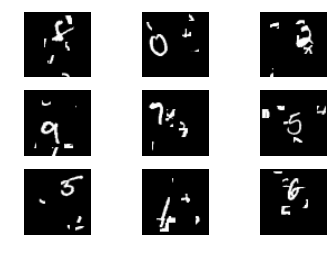

In [30]:
# input
for i in range(9):
    plt.subplot(3, 3, i+1)
    #plt.imshow(Xaug[i, 0], cmap='gray')
    plt.imshow(np.squeeze(Xaug[i]), cmap='gray')
    plt.axis('off')    

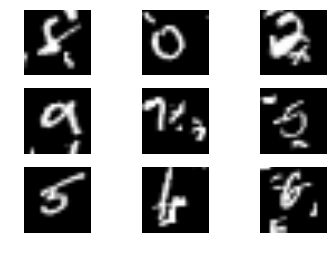

In [31]:
# output
for i in range(9):
    plt.subplot(3, 3, i+1)
    #plt.imshow(Xresult[i, 0], cmap='gray')
    plt.imshow(np.squeeze(Xresult[0][i]), cmap='gray')
    plt.axis('off')
    